## 04_modeling_m_logreg_sgd
  
Mourad Askar

**Logistic Regression and SGD Models to predict if a crash has_injuries**  
  
Create Models to predict if a crash has_injuries:  
- 0: NO INJURY
- 1: HAS INJURY  

Steps per Model:
- Create 2019 Model using Training and Validation split
    - Use Grid Search to find best hyperparameters
    - Grid Search will use 2019 Training set for CrossValidation
- Using 2019 Fitted Model
    - Test 2019 Model on 2019 test data with best hyperparameters
    - Test 2019 Model on 2020 data with best hyperparameters  
- Handling Class Imbalance
    - Each model is tested using class_weight='balanced'
    - Then Each model is tested using a resampled dataset

Report for each model run:  
- Best Hyperparameters
- Model scores

In [1]:
import pandas as pd
import numpy as np
import klib
import pandas_profiling as pp
import sweetviz
import sklearn

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import *
from imblearn.over_sampling import *
from imblearn.under_sampling import *

from sklearn.utils import *
from sklearn.model_selection import train_test_split
from platform import python_version

from sklearn.tree import export_graphviz
import graphviz

%precision 2

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.width = 120
pd.options.display.float_format='{:,.2g}'.format
pd.options.display.precision = 2

np.set_printoptions(precision=2, linewidth=120, suppress=True, edgeitems=5)

sns.set_style("white")

StartBold = "\033[1m"
EndBold = "\033[0m"

print('python',python_version())
print(np.__name__, np.__version__)
print(pd.__name__, pd.__version__)
print(klib.__name__, klib.__version__)
#print(pp.__name__, pp.__version__)
print(sklearn.__name__, sklearn.__version__)
print(sweetviz.__name__, sweetviz.__version__)

python 3.9.2
numpy 1.20.1
pandas 1.1.4
klib 0.1.5
sklearn 0.24.1
sweetviz 2.0.9


In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, LogisticRegressionCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.kernel_approximation import RBFSampler

from sklearn.svm import SVC

from sklearn import metrics

In [3]:
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
#%config InlineBackend.figure_formats = ['png', 'retina', 'jpeg', 'svg', 'pdf']

In [4]:
from sklearn import set_config
set_config(display='diagram') 

In [5]:
# Global Parameters

random_state = 2021
n_jobs = 4

# Define Dictionary Mappers

In [6]:
week_days = {0:'Sunday',1:'Monday',2:'Tuesday',3:'Wednesday',4:'Thursday',5:'Friday',6:'Saturday'}
is_weekday = {0:'Weekend',1:'Weekday'}

# Read Data

In [7]:
#file_parquet_c = '20210203_chi_crashes_c.parquet'
#file_parquet_c = '20210228_chi_crashes_c.parquet'
file_crash_df_parquet = 'crash_df.parquet'

crash_df = pd.read_parquet(file_crash_df_parquet)

crash_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478484 entries, 0 to 481622
Data columns (total 32 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   crash_date               478484 non-null  datetime64[ns]
 1   crash_year               478484 non-null  int16         
 2   crash_month              478484 non-null  int8          
 3   crash_day_of_week        478484 non-null  int8          
 4   crash_hour               478484 non-null  int8          
 5   crash_time_of_day        478484 non-null  category      
 6   latitude                 478484 non-null  float32       
 7   longitude                478484 non-null  float32       
 8   beat_of_occurrence       478484 non-null  int64         
 9   address                  478484 non-null  string        
 10  street_no                478484 non-null  category      
 11  street_direction         478484 non-null  category      
 12  street_name     

# Engineer New Features

In [8]:
crash_df['is_weekday'] = crash_df.crash_day_of_week.map(lambda x: 0 if x in [1,7] else 1)


# Select Features of interest

In [9]:
features_names = [
#    'crash_date',
    'crash_year',
    'crash_month',
#    'crash_day_of_week',
#    'crash_hour',
    'crash_time_of_day', # New
    'is_weekday', #New
    'latitude',
    'longitude',
#    'beat_of_occurrence', # Should be considered as categorical, don't scale.
#    'address',
#    'street_no',
#    'street_direction',
#    'street_name',
    'posted_speed_limit',
    'traffic_control_device',
    'device_condition',
    'weather_condition',
    'lighting_condition',
    'trafficway_type',
    'alignment',
    'roadway_surface_cond',
    'road_defect',
    'first_crash_type',
    'prim_contributory_cause',
    'sec_contributory_cause',
    'num_units',
#    'intersection_related_i',
#    'not_right_of_way_i',
#    'hit_and_run_i',
]

target_names = [
    'has_injuries',  # New
#    'has_fatal',  # New
#    'crash_type',
#    'damage',
#    'injuries_total',
#    'injuries_fatal',
#    'injuries_incapacitating',
#    'inj_non_incap',
#    'inj_report_not_evdnt',
#    'injuries_no_indication',
#    'most_severe_injury',
]

all_columns = features_names + target_names
all_columns

['crash_year',
 'crash_month',
 'crash_time_of_day',
 'is_weekday',
 'latitude',
 'longitude',
 'posted_speed_limit',
 'traffic_control_device',
 'device_condition',
 'weather_condition',
 'lighting_condition',
 'trafficway_type',
 'alignment',
 'roadway_surface_cond',
 'road_defect',
 'first_crash_type',
 'prim_contributory_cause',
 'sec_contributory_cause',
 'num_units',
 'has_injuries']

# Filter for only 2019

In [10]:
#crash_df = crash_df[(crash_df.crash_year>2017) & (crash_df.crash_year<2021)]
crash_2019_df = crash_df.query('crash_year == 2019')[all_columns[1:]] # drop year column
crash_2019_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116723 entries, 0 to 481575
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   crash_month              116723 non-null  int8    
 1   crash_time_of_day        116723 non-null  category
 2   is_weekday               116723 non-null  int64   
 3   latitude                 116723 non-null  float32 
 4   longitude                116723 non-null  float32 
 5   posted_speed_limit       116723 non-null  int64   
 6   traffic_control_device   116723 non-null  category
 7   device_condition         116723 non-null  category
 8   weather_condition        116723 non-null  category
 9   lighting_condition       116723 non-null  category
 10  trafficway_type          116723 non-null  category
 11  alignment                116723 non-null  category
 12  roadway_surface_cond     116723 non-null  category
 13  road_defect              116723 non-null  ca

# Filter for only 2020

In [11]:
crash_2020_df = crash_df.query('crash_year == 2020')[all_columns[1:]] # drop year column
crash_2020_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91332 entries, 2 to 481574
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   crash_month              91332 non-null  int8    
 1   crash_time_of_day        91332 non-null  category
 2   is_weekday               91332 non-null  int64   
 3   latitude                 91332 non-null  float32 
 4   longitude                91332 non-null  float32 
 5   posted_speed_limit       91332 non-null  int64   
 6   traffic_control_device   91332 non-null  category
 7   device_condition         91332 non-null  category
 8   weather_condition        91332 non-null  category
 9   lighting_condition       91332 non-null  category
 10  trafficway_type          91332 non-null  category
 11  alignment                91332 non-null  category
 12  roadway_surface_cond     91332 non-null  category
 13  road_defect              91332 non-null  category
 14  first

# Determine features / target

In [12]:
features_2019 = crash_2019_df[features_names[1:]].copy() # skip year column
target_2019 = crash_2019_df[target_names].has_injuries.copy()
#target_2019 = crash_2019_df[target_names].crash_type.copy()
#target_2019 = target_2019.map({'NO INJURY / DRIVE AWAY':0,'INJURY AND / OR TOW DUE TO CRASH':1})

features_2020 = crash_2020_df[features_names[1:]].copy() # skip year column
target_2020 = crash_2020_df[target_names].has_injuries.copy()
#target_2020 = crash_2020_df[target_names].crash_type.copy()
#target_2020 = target_2020.map({'NO INJURY / DRIVE AWAY':0,'INJURY AND / OR TOW DUE TO CRASH':1})

features_2019.shape, target_2019.shape

((116723, 18), (116723,))

# Create Dummies

In [13]:
features_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116723 entries, 0 to 481575
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   crash_month              116723 non-null  int8    
 1   crash_time_of_day        116723 non-null  category
 2   is_weekday               116723 non-null  int64   
 3   latitude                 116723 non-null  float32 
 4   longitude                116723 non-null  float32 
 5   posted_speed_limit       116723 non-null  int64   
 6   traffic_control_device   116723 non-null  category
 7   device_condition         116723 non-null  category
 8   weather_condition        116723 non-null  category
 9   lighting_condition       116723 non-null  category
 10  trafficway_type          116723 non-null  category
 11  alignment                116723 non-null  category
 12  roadway_surface_cond     116723 non-null  category
 13  road_defect              116723 non-null  ca

In [14]:
#features_2019['crash_month'] = features_2019['crash_month'].astype('category')
##features_2019['beat_of_occurrence'] = features_2019['beat_of_occurrence'].astype('category')
##features_2019['address'] = features_2019['address'].astype('category')

#features_2020['crash_month'] = features_2020['crash_month'].astype('category')
##features_2020['beat_of_occurrence'] = features_2020['beat_of_occurrence'].astype('category')
##features_2020['address'] = features_2020['address'].astype('category')

In [15]:
features_2019_dm = pd.get_dummies(features_2019)
features_2020_dm = pd.get_dummies(features_2020)

In [16]:
# Split data into Features X and Target y
X = features_2019_dm
y = target_2019
print('X and y shapes:')
print(X.shape,y.shape,'\n')
print('Target Ratio:')
print(y.value_counts(normalize=True, dropna=False),'\n')

X and y shapes:
(116723, 193) (116723,) 

Target Ratio:
0   0.86
1   0.14
Name: has_injuries, dtype: float64 



In [17]:
X

,crash_month,is_weekday,latitude,longitude,posted_speed_limit,num_units,crash_time_of_day_overnight,crash_time_of_day_morning,crash_time_of_day_mid_day,crash_time_of_day_evening,traffic_control_device_BICYCLE CROSSING SIGN,traffic_control_device_DELINEATORS,traffic_control_device_FLASHING CONTROL SIGNAL,traffic_control_device_LANE USE MARKING,traffic_control_device_NO CONTROLS,traffic_control_device_NO PASSING,traffic_control_device_OTHER,traffic_control_device_OTHER RAILROAD CROSSING,traffic_control_device_OTHER REG. SIGN,traffic_control_device_OTHER WARNING SIGN,traffic_control_device_PEDESTRIAN CROSSING SIGN,traffic_control_device_POLICE/FLAGMAN,traffic_control_device_RAILROAD CROSSING GATE,traffic_control_device_RR CROSSING SIGN,traffic_control_device_SCHOOL ZONE,traffic_control_device_STOP SIGN/FLASHER,traffic_control_device_TRAFFIC SIGNAL,traffic_control_device_UNKNOWN,traffic_control_device_YIELD,device_condition_FUNCTIONING IMPROPERLY,device_condition_FUNCTIONING PROPERLY,device_condition_MISSING,device_condition_NO CONTROLS,device_condition_NOT FUNCTIONING,device_condition_OTHER,device_condition_UNKNOWN,device_condition_WORN REFLECTIVE MATERIAL,"weather_condition_BLOWING SAND, SOIL, DIRT",weather_condition_BLOWING SNOW,weather_condition_CLEAR,weather_condition_CLOUDY/OVERCAST,weather_condition_FOG/SMOKE/HAZE,weather_condition_FREEZING RAIN/DRIZZLE,weather_condition_OTHER,weather_condition_RAIN,weather_condition_SEVERE CROSS WIND GATE,weather_condition_SLEET/HAIL,weather_condition_SNOW,weather_condition_UNKNOWN,lighting_condition_DARKNESS,...,prim_contributory_cause_PHYSICAL CONDITION OF DRIVER,prim_contributory_cause_RELATED TO BUS STOP,prim_contributory_cause_ROAD CONSTRUCTION/MAINTENANCE,prim_contributory_cause_ROAD ENGINEERING/SURFACE/MARKING DEFECTS,prim_contributory_cause_TEXTING,prim_contributory_cause_TURNING RIGHT ON RED,prim_contributory_cause_UNABLE TO DETERMINE,prim_contributory_cause_UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED),"prim_contributory_cause_VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)",prim_contributory_cause_WEATHER,sec_contributory_cause_ANIMAL,sec_contributory_cause_BICYCLE ADVANCING LEGALLY ON RED LIGHT,sec_contributory_cause_CELL PHONE USE OTHER THAN TEXTING,sec_contributory_cause_DISREGARDING OTHER TRAFFIC SIGNS,sec_contributory_cause_DISREGARDING ROAD MARKINGS,sec_contributory_cause_DISREGARDING STOP SIGN,sec_contributory_cause_DISREGARDING TRAFFIC SIGNALS,sec_contributory_cause_DISREGARDING YIELD SIGN,sec_contributory_cause_DISTRACTION - FROM INSIDE VEHICLE,sec_contributory_cause_DISTRACTION - FROM OUTSIDE VEHICLE,"sec_contributory_cause_DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)",sec_contributory_cause_DRIVING ON WRONG SIDE/WRONG WAY,sec_contributory_cause_DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,sec_contributory_cause_EQUIPMENT - VEHICLE CONDITION,"sec_contributory_cause_EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST",sec_contributory_cause_EXCEEDING AUTHORIZED SPEED LIMIT,sec_contributory_cause_EXCEEDING SAFE SPEED FOR CONDITIONS,sec_contributory_cause_FAILING TO REDUCE SPEED TO AVOID CRASH,sec_contributory_cause_FAILING TO YIELD RIGHT-OF-WAY,sec_contributory_cause_FOLLOWING TOO CLOSELY,sec_contributory_cause_HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE),sec_contributory_cause_IMPROPER BACKING,sec_contributory_cause_IMPROPER LANE USAGE,sec_contributory_cause_IMPROPER OVERTAKING/PASSING,sec_contributory_cause_IMPROPER TURNING/NO SIGNAL,sec_contributory_cause_MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT,sec_contributory_cause_NOT APPLICABLE,sec_contributory_cause_OBSTRUCTED CROSSWALKS,"sec_contributory_cause_OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER",sec_contributory_cause_PASSING STOPPED SCHOOL BUS,sec_contributory_cause_PHYSICAL CONDITION OF DRIVER,sec_contributory_cause_RELATED TO BUS STOP,sec_contributory_cause_ROAD CONSTRUCTION/MAINTENANCE,sec_contributory_cause_ROAD ENGINEERING/SURF

# Create 2019 Train/Test datasets

In [18]:
# Split data into Train and Test
# We stratify to make sure target representation is kept in the new datasets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.2,
#                                                    stratify=y,
                                                    random_state=random_state)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((93378, 193), (23345, 193), (93378,), (23345,))

In [19]:
print('Training Data:')
print('--------------')
print('X and y shapes:')
print(X_train.shape,y_train.shape,'\n')
print('Target Ratio:')
print(y_train.value_counts(normalize=True, dropna=False),'\n')

Training Data:
--------------
X and y shapes:
(93378, 193) (93378,) 

Target Ratio:
0   0.86
1   0.14
Name: has_injuries, dtype: float64 



In [20]:
print('Testing Data:')
print('-------------')
print('X and y shapes:')
print(X_test.shape,y_test.shape,'\n')
print('Target Ratio:')
print(y_test.value_counts(normalize=True, dropna=False),'\n')

Testing Data:
-------------
X and y shapes:
(23345, 193) (23345,) 

Target Ratio:
0   0.86
1   0.14
Name: has_injuries, dtype: float64 



It's visible that we have an imbalanced target that we need to consider during our evaluations.

# Resampling (Obsolete)

**NOTE: Decided to utilize class_weight='balanced' in models for better management**

Resampling to compensate the target class that has low representation.

In [21]:
#'''
ros = RandomOverSampler(random_state=random_state)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

print('Testing Data:')
print('-------------')
print('X and y shapes:')
print(X_train_resampled.shape,y_train_resampled.shape,'\n')
print('Target Ratio:')
print(y_train_resampled.value_counts(normalize=True, dropna=False),'\n')
#''';

Testing Data:
-------------
X and y shapes:
(160780, 193) (160780,) 

Target Ratio:
1   0.5
0   0.5
Name: has_injuries, dtype: float64 



In [22]:
#X_train

# Scaling Data (Obsolete)

**NOTE: Decided to perform scaling using pipelines for better management**

I have considered whether I should scale/normalize the dataset, then I realized that most of my features are categorical that are now expanded into 1 hot encoded dummy variables. The other Integer variables I also assume that they can be used as is, as they can represent ordinal values. Anyway, I will be testing the normalization during my steps.

In [23]:
'''
X_train_Scaler = MinMaxScaler().fit(X_train)
X_train_mms = X_train_Scaler.transform(X_train) # mms = MinMaxScaled

X_train_resampled_Scaler = MinMaxScaler().fit(X_train_resampled)
X_train_resampled_mms = X_train_resampled_Scaler.transform(X_train_resampled)

X_test_mms = X_train_Scaler.transform(X_test)
X_test_rs_mms = X_train_resampled_Scaler.transform(X_test)
''';

In [24]:
#X_train_mms

# Helper Functions

In [25]:
def get_GS_cv_results(gs):
    _cv_results_ = gs.cv_results_
    _scorer_keys = gs.scorer_.keys()

    df_gs_scores = pd.DataFrame()

    for k in _cv_results_.keys():
        if k.startswith('param_'):
            param_key = ('param',k.split('_',1)[1])
            param_values = _cv_results_[k]
            df_gs_scores = pd.concat([df_gs_scores,pd.DataFrame({param_key:param_values})], axis=1)

        elif k.startswith('mean_train') or k.startswith('mean_test'):
            score_key = (k.split('_',2)[2],k.split('_',2)[1])
            score_results = _cv_results_[k]
            df_gs_scores = pd.concat([df_gs_scores,pd.DataFrame({score_key:score_results})], axis=1)

    return df_gs_scores

def plot_grid_search_scores_grid(gs, display_plots=False):
    _cv_results_ = gs.cv_results_
    _scorer_keys = gs.scorer_.keys()
    _param_keys = list(_cv_results_['params'][0].keys())
    df_gs_scores = get_GS_cv_results(gs)
    
    display(df_gs_scores)
    
    if(display_plots):
        if len(_param_keys) > 1:
            for _score in _scorer_keys:
                dd = df_gs_scores[['param',_score]]
                dd.columns = dd.columns.droplevel(0)
                ddm = dd.melt(id_vars=_param_keys[:2],value_vars=['train','test'],var_name='dataset',value_name=_score)
                g = sns.FacetGrid(ddm,col=_param_keys[0],height=3)
                g.map_dataframe(sns.lineplot,_param_keys[1],_score,'dataset')
                g.add_legend()
        else:
            for _score in _scorer_keys:
                dd = df_gs_scores[['param',_score]]
                dd.columns = dd.columns.droplevel(0)
                ddm = dd.melt(id_vars=_param_keys,value_vars=['train','test'],var_name='dataset',value_name=_score)
                g = sns.FacetGrid(ddm, height=3)
                g.map_dataframe(sns.lineplot,_param_keys[0],_score,'dataset')
                g.add_legend()

def plot_grid_search_results(gs, plot_scoring='r2'):
    _cv_results_ = gs.cv_results_
    _scorer_keys = gs.scorer_.keys()
    
    print(f'{StartBold}Estimator:{EndBold}')
    print(gs.best_estimator_)
    print()
    print(f'{StartBold}Best Result (Suggested):{EndBold}')
    print(f'{StartBold}\t{"":20} {"train":>6} {"valdn":>6}{EndBold}')
    for _score in _scorer_keys:
        print('\t{2:>20} {0:>6.2f} {1:>6.2f}'.format(_cv_results_['mean_train_' + _score][gs.best_index_],
                                             _cv_results_['mean_test_' + _score][gs.best_index_],
                                             _score))
    print()
    print(f'{StartBold}Params:{EndBold}')
    print('\t{}'.format(gs.best_params_))
    print()
    
 
    scoring_label = plot_scoring
    not_negative = 1
    if plot_scoring.startswith('neg_'):
        scoring_label = plot_scoring[4:]
        not_negative = -1
    df = pd.DataFrame({
        'params': _cv_results_['params'],
        'mean_train_' + plot_scoring: _cv_results_['mean_train_' + plot_scoring] * not_negative,
        'mean_test_' + plot_scoring: _cv_results_['mean_test_' + plot_scoring] * not_negative
    })
    fig, ax = plt.subplots()
    df.plot('params',['mean_train_' + plot_scoring,'mean_test_' + plot_scoring], 'line', ax=ax)
    ax.axvline(gs.best_index_,0,1, color='r', linestyle='--')
    plt.grid(axis='both',c='lightgrey',ls=':')
    plt.xticks(ticks=range(df.params.count()), labels=df.params)
    plt.tick_params(axis='x', rotation=90)
    plt.ylabel(scoring_label)
    plt.legend(['train','valdn'])
    plt.show()
    
    #_ = gs
    #df_ = pd.DataFrame(_.cv_results_).filter(regex='(?:mean_test)|(?:params)')
    #df_.insert(0,'classifier',_.best_estimator_.named_steps.classifier.__class__.__name__)
    #d_result = {_.best_estimator_.named_steps.classifier:dict(df_.iloc[_.best_index_])}
    #d_result
    plot_grid_search_scores_grid(gs)

    if("beep" in globals()): beep(True)
        
def score_classification_model(fitted_model, X, y_true, return_score=False):
    p = fitted_model.predict(X)
    
    accuracy = metrics.accuracy_score(y_true, p)
    f1 = metrics.f1_score(y_true, p)
    recall = metrics.recall_score(y_true, p)
    precision = metrics.precision_score(y_true, p)
    balanced_accuracy = metrics.balanced_accuracy_score(y_true, p)
    roc = metrics.roc_auc_score(y_true, p)

    print('accuracy score:          {:>5.2f}'.format(accuracy))
    print('f1 score:                {:>5.2f}'.format(f1))
    print('recall score:            {:>5.2f}'.format(recall))
    print('precision score:         {:>5.2f}'.format(precision))
    print('balanced_accuracy score: {:>5.2f}'.format(balanced_accuracy))
    print('roc_auc score:           {:>5.2f}'.format(roc))

    #print(metrics.classification_report(y_true,p))
    metrics.plot_confusion_matrix(fitted_model,X, y_true)
    plt.show()
          
    #print(metrics.classification_report(y_true,p, sample_weight=compute_sample_weight('balanced',y_true)))
    #metrics.plot_confusion_matrix(fitted_model,X, y_true, sample_weight=compute_sample_weight('balanced',y_true))

    if((type(return_score) is str) or return_score):
        if(type(fitted_model) == GridSearchCV):
            model = fitted_model.best_estimator_
            if(type(model) == Pipeline):
                model = fitted_model.best_estimator_.named_steps.classifier
        else:
            model = fitted_model
        key = str(model).replace('\n','').replace('\t','') + ( (' - ' + return_score) if type(return_score) == str else '')
        results_dict = {key : {}}
        results_dict[key]['Estimator'] = model.__class__.__name__
        results_dict[key]['TAG'] = return_score if type(return_score) == str else '-'
        results_dict[key]['Accuracy'] = accuracy
        results_dict[key]['F1'] = f1
        results_dict[key]['Recall'] = recall
        results_dict[key]['Precision'] = precision
        results_dict[key]['Balanced_Accuracy'] = balanced_accuracy
        results_dict[key]['ROC_AUC'] = roc
        return(results_dict)
    
def plot_coefficients(coef, feature_names, top_n=0):
    _ = pd.DataFrame({'features':feature_names,'coef':coef}).sort_values('coef',key=lambda x: abs(x),ascending=False)
    if top_n > 0:
        _ = _.iloc[:top_n,:]
    n_features = _.shape[0]
    #plt.subplots(figsize=(10,20))
    plt.barh(range(n_features), _['coef'], align='center')
    plt.yticks(np.arange(n_features), _['features'])
    plt.xlabel('Value')
    plt.ylabel('Feature')
    plt.ylim(n_features,-1)
    plt.show()


In [26]:
#compute_class_weight('balanced',classes=[0,1],y=y_train)
#compute_sample_weight('balanced',y_train)

# Models

## Common GridSearch Params

In [27]:
# Common Grid Search Parameters

grid_search_defaults = {
    'cv': 3,
    'scoring': ['f1', 'recall', 'precision', 'balanced_accuracy', 'accuracy', 'roc_auc'],
    'refit': 'f1',
    'return_train_score': True,
    'error_score': 0,
    'verbose': 3,
    'n_jobs': n_jobs,
}

## Init Scores Dictionary

In [28]:
scores_2020 = {}

# [**RUN ALL ABOVE BEFORE ANY MODEL**]

## Logistic Regression

Fitting 3 folds for each of 7 candidates, totalling 21 fits


2019 Train_Set Tuning Results:
Estimator:
Pipeline(steps=[('scale', MinMaxScaler()),
                ('classifier',
                 LogisticRegression(C=10.0, class_weight='balanced',
                                    n_jobs=4))])

Best Result (Suggested):
	                      train  valdn
	                  f1   0.45   0.44
	              recall   0.71   0.70
	           precision   0.33   0.33
	   balanced_accuracy   0.74   0.73
	            accuracy   0.76   0.76
	             roc_auc   0.83   0.82

Params:
	{'classifier__C': 10.0}



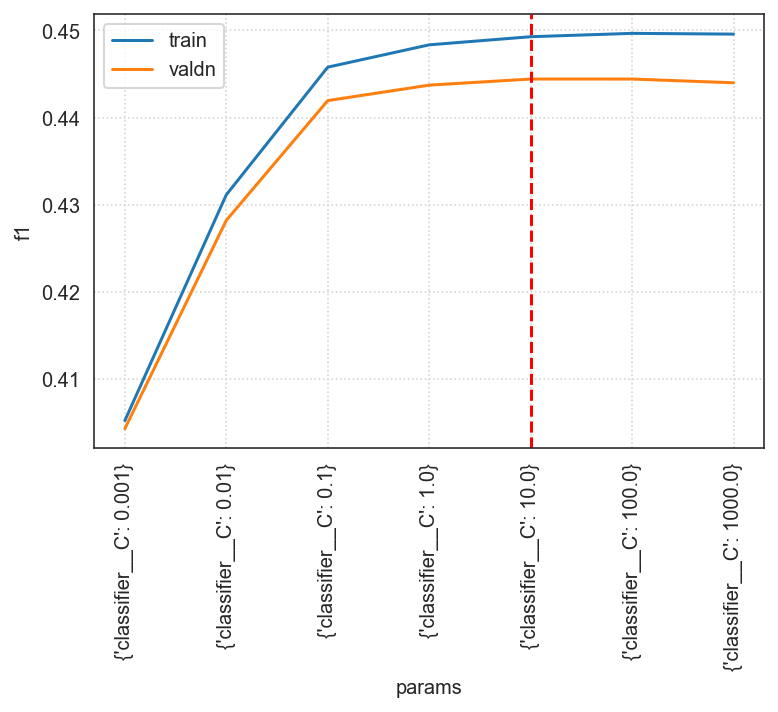

param   f1       recall       precision       balanced_accuracy       accuracy       roc_auc      
  classifier__C test train   test train      test train              test train     test train    test train
0         0.001  0.4  0.41   0.72  0.72      0.28  0.28              0.71  0.71     0.71  0.71    0.79  0.79
1          0.01 0.43  0.43    0.7  0.71      0.31  0.31              0.72  0.73     0.74  0.74    0.81  0.82
2           0.1 0.44  0.45   0.71  0.71      0.32  0.32              0.73  0.74     0.75  0.75    0.82  0.82
3             1 0.44  0.45    0.7  0.71      0.32  0.33              0.73  0.74     0.76  0.76    0.82  0.83
4            10 0.44  0.45    0.7  0.71      0.33  0.33              0.73  0.74     0.76  0.76    0.82  0.83
5         1e+02 0.44  0.45    0.7  0.71      0.33  0.33              0.73  0.74     0.76  0.76    0.82  0.83
6         1e+03 0.44  0.45    0.7  0.71      0.33  0.33              0.73  0.74     0.76  0.76    0.82  0.83



2019 Test_Set Results:
accuracy score:           0.76
f1 score:                 0.44
recall score:             0.69
precision score:          0.32
balanced_accuracy score:  0.73
roc_auc score:            0.73


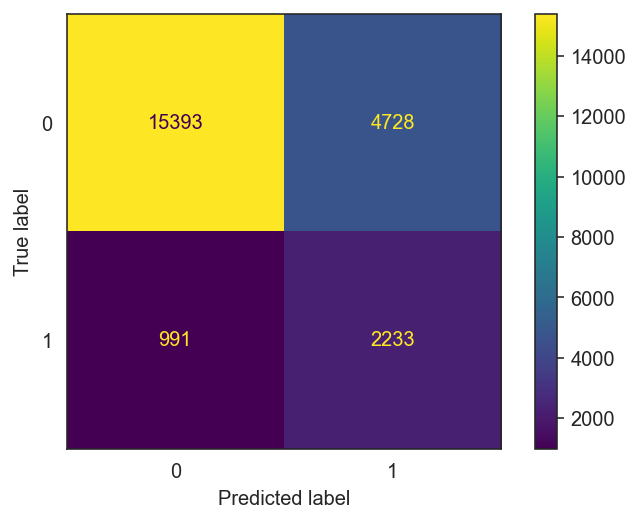



2020 Results:
accuracy score:           0.73
f1 score:                 0.44
recall score:             0.71
precision score:          0.32
balanced_accuracy score:  0.72
roc_auc score:            0.72


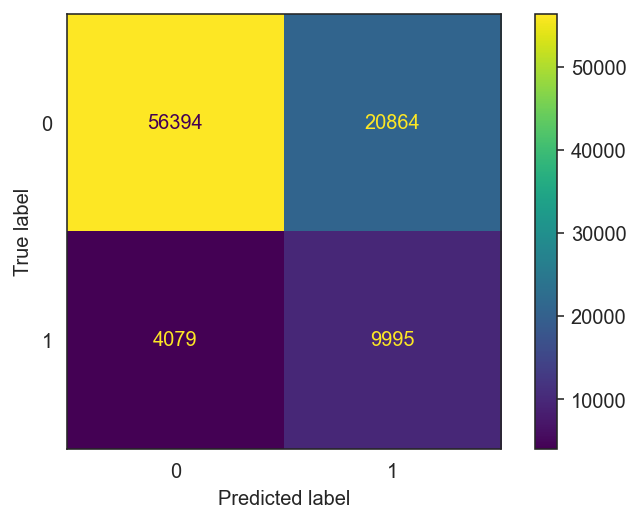

In [29]:
cl_pl = Pipeline(
    steps=[
        ('scale', MinMaxScaler()),
        ('classifier', LogisticRegression(n_jobs=n_jobs,class_weight='balanced'))
    ]
)

params = {
    'classifier__C': np.logspace(-3,3,7),
}
gs_lr = GridSearchCV(
    cl_pl,
    params, **grid_search_defaults
)
gs_lr.fit(
    X_train,
    y_train
)

print(f'\n\n{StartBold}2019 Train_Set Tuning Results:{EndBold}')
plot_grid_search_results(gs_lr, grid_search_defaults['refit'])
print(f'\n\n{StartBold}2019 Test_Set Results:{EndBold}')
score_classification_model(gs_lr, X_test, y_test)
print(f'\n\n{StartBold}2020 Results:{EndBold}')
results = score_classification_model(gs_lr, features_2020_dm, target_2020, True)
scores_2020.update(results)

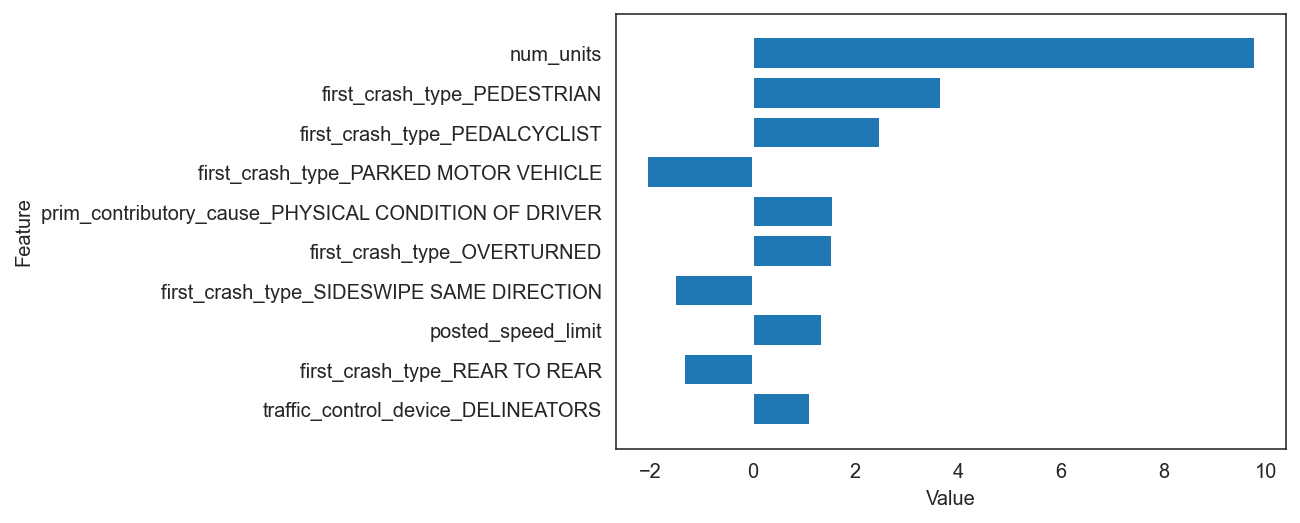

In [30]:
plot_coefficients(gs_lr.best_estimator_.named_steps.classifier.coef_.ravel(),X.columns,10)

In [31]:
cl_pl = Pipeline(
    steps=[
        ('scale', MinMaxScaler()),
        ('classifier', LogisticRegression(n_jobs=n_jobs,class_weight='balanced'))
    ]
)

params = {
    'classifier__C': np.logspace(-3,3,7),
}
gs_lr = GridSearchCV(
    cl_pl,
    params, **grid_search_defaults
)
gs_lr.fit(
    X_train_resampled,
    y_train_resampled
)

print(f'\n\n{StartBold}2019 Train_Set Tuning Results:{EndBold}')
plot_grid_search_results(gs_lr, grid_search_defaults['refit'])
print(f'\n\n{StartBold}2019 Test_Set Results:{EndBold}')
score_classification_model(gs_lr, X_test, y_test)
print(f'\n\n{StartBold}2020 Results:{EndBold}')
results = score_classification_model(gs_lr, features_2020_dm, target_2020, 'resampled')
scores_2020.update(results)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


/usr/local/Caskroom/miniconda/base/envs/depaul/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
plot_coefficients(gs_lr.best_estimator_.named_steps.classifier.coef_.ravel(),X.columns,10)

## SGDClassifier

Fitting 3 folds for each of 15 candidates, totalling 45 fits


2019 Train_Set Tuning Results:
Estimator:
Pipeline(steps=[('scale', MinMaxScaler()),
                ('classifier',
                 SGDClassifier(class_weight='balanced', l1_ratio=0.5,
                               loss='log', n_jobs=4))])

Best Result (Suggested):
	                      train  valdn
	                  f1   0.47   0.46
	              recall   0.61   0.60
	           precision   0.39   0.38
	   balanced_accuracy   0.72   0.72
	            accuracy   0.80   0.80
	             roc_auc   0.82   0.82

Params:
	{'classifier__alpha': 0.0001, 'classifier__l1_ratio': 0.5}



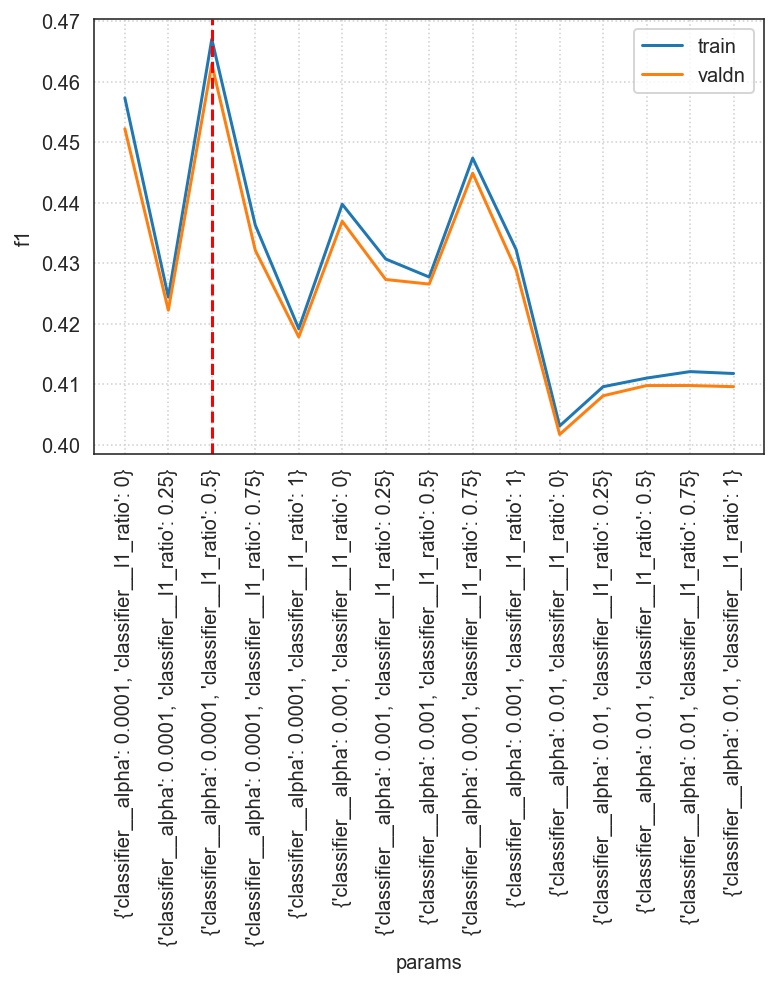

param                        f1       recall       precision       balanced_accuracy       accuracy  \
   classifier__alpha classifier__l1_ratio test train   test train      test train              test train     test   
0             0.0001                    0 0.45  0.46   0.65  0.65      0.35  0.35              0.72  0.73     0.78   
1             0.0001                 0.25 0.42  0.42   0.74  0.74       0.3   0.3              0.72  0.72     0.71   
2             0.0001                  0.5 0.46  0.47    0.6  0.61      0.38  0.39              0.72  0.72      0.8   
3             0.0001                 0.75 0.43  0.44   0.71  0.72      0.31  0.31              0.73  0.73     0.74   
4             0.0001                    1 0.42  0.42   0.75  0.75      0.29  0.29              0.72  0.73      0.7   
5              0.001                    0 0.44  0.44   0.68  0.68      0.32  0.32              0.72  0.73     0.76   
6              0.001                 0.25 0.43  0.43   0.71  0.72      0.31  0.31              0.72  0.73     0.73   
7              0.001                  0.5 0.43  0.43   0.72  0.72       0.3  0.31              0.72  0.73     0.73   
8              0.001                 0.75 0.44  0.45   0.66  0.67      0.34  0.34              0.72  0.73     0.77   
9              0.001                    1 0.43  0.43   0.71  0.71      0.31  0.31              0.73  0.73     0.74   
10              0.01                    0  0.4   0.4   0.74  0.74      0.28  0.28              0.71  0.71     0.69   
11              0.01                 0.25 0.41  0.41   0.72  0.72      0.29  0.29              0.71  0.72     0.71   
12              0.01                  0.5 0.41  0.41   0.71  0.72      0.29  0.29              0.71  0.71     0.71   
13              0.01                 0.75 0.41  0.41   0.71  0.72      0.29  0.29              0.71  0.72     0.71   
14              0.01                    1 0.41  0.41   0.71  0.71      0.29  0.29              0.71  0.72     0.71   

         roc_auc        
   train    test train  
0   0.78    0.82  0.82  
1   0.71    0.82  0.82  
2    0.8    0.82  0.82  
3   0.74    0.82  0.82  
4    0.7    0.82  0.82  
5   0.76    0.81  0.82  
6   0.74    0.81  0.82  
7   0.73    0.81  0.82  
8   0.77    0.81  0.82  
9   0.74    0.81  0.82  
10  0.69     0.8   0.8  
11  0.71     0.8   0.8  
12  0.71     0.8   0.8  
13  0.72     0.8   0.8  
14  0.72     0.8   0.8



2019 Test_Set Results:
accuracy score:           0.81
f1 score:                 0.46
recall score:             0.58
precision score:          0.37
balanced_accuracy score:  0.71
roc_auc score:            0.71


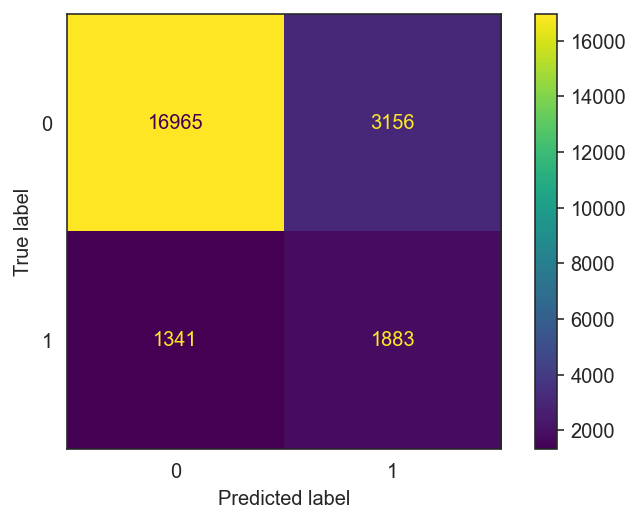



2020 Results:
accuracy score:           0.78
f1 score:                 0.46
recall score:             0.61
precision score:          0.37
balanced_accuracy score:  0.71
roc_auc score:            0.71


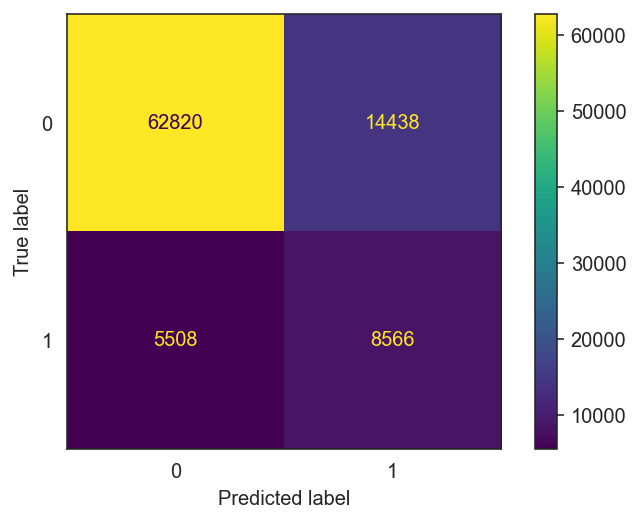

In [35]:
cl_pl = Pipeline(
    steps=[
        ('scale', MinMaxScaler()),
        ('classifier', SGDClassifier(loss='log',n_jobs=n_jobs,class_weight='balanced'))
    ]
)

params = {
#    'classifier__class_weight': ['balanced',{1:2},{1:3},{1:4}],
    'classifier__l1_ratio': [0,.25,.5,.75,1],
    'classifier__alpha': [1e-4, 1e-3, 1e-2],#np.logspace(-4,-3,5).round(5),
#    'classifier__alpha': [.0006,.0007,.0008],
}
gs_sgd = GridSearchCV(
    cl_pl,
    params, **grid_search_defaults
)
gs_sgd.fit(
    X_train,
    y_train
)

print(f'\n\n{StartBold}2019 Train_Set Tuning Results:{EndBold}')
plot_grid_search_results(gs_sgd, grid_search_defaults['refit'])
print(f'\n\n{StartBold}2019 Test_Set Results:{EndBold}')
score_classification_model(gs_sgd, X_test, y_test)
print(f'\n\n{StartBold}2020 Results:{EndBold}')
results = score_classification_model(gs_sgd, features_2020_dm, target_2020, True)
scores_2020.update(results)

In [ ]:
plot_coefficients(gs_sgd.best_estimator_.named_steps.classifier.coef_.ravel(),X.columns,10)

In [ ]:
cl_pl = Pipeline(
    steps=[
        ('scale', MinMaxScaler()),
        ('classifier', SGDClassifier(loss='log',n_jobs=n_jobs,class_weight='balanced'))
    ]
)

params = {
    'classifier__l1_ratio': [0,.25,.5,.75,1],
    'classifier__alpha': [1e-4, 1e-3, 1e-2],#np.logspace(-4,-3,5).round(5),
#    'classifier__alpha': [.0006,.0007,.0008],
}
gs_sgd = GridSearchCV(
    cl_pl,
    params, **grid_search_defaults
)
gs_sgd.fit(
    X_train_resampled,
    y_train_resampled
)

print(f'\n\n{StartBold}2019 Train_Set Tuning Results:{EndBold}')
plot_grid_search_results(gs_sgd, grid_search_defaults['refit'])
print(f'\n\n{StartBold}2019 Test_Set Results:{EndBold}')
score_classification_model(gs_sgd, X_test, y_test)
print(f'\n\n{StartBold}2020 Results:{EndBold}')
results = score_classification_model(gs_sgd, features_2020_dm, target_2020, 'resampled')
scores_2020.update(results)

In [ ]:
plot_coefficients(gs_sgd.best_estimator_.named_steps.classifier.coef_.ravel(),X.columns,10)

## Kernel Approximation

In [ ]:
cl_pl = Pipeline(
    steps=[
        ('scale', MinMaxScaler()),
        ('rbf', RBFSampler(random_state=random_state)),
        ('classifier', SGDClassifier(class_weight='balanced', random_state=random_state, n_jobs=n_jobs))
    ])

params = {
    'rbf__gamma': np.logspace(-4,0,5),
#    'classifier__alpha': np.logspace(-5,0,5),
    'classifier__alpha': 10.0**-np.arange(1,7),
}
gs_sgdka = GridSearchCV(
    cl_pl,
    params, **grid_search_defaults
)
gs_sgdka.fit(
    X_train,
    y_train
)

print(f'\n\n{StartBold}2019 Train_Set Tuning Results:{EndBold}')
plot_grid_search_results(gs_sgdka, grid_search_defaults['refit'])
print(f'\n\n{StartBold}2019 Test_Set Results:{EndBold}')
score_classification_model(gs_sgdka, X_test, y_test)
print(f'\n\n{StartBold}2020 Results:{EndBold}')
results = score_classification_model(gs_sgdka, features_2020_dm, target_2020, 'KA')
scores_2020.update(results)

In [ ]:
cl_pl = Pipeline(
    steps=[
        ('scale', MinMaxScaler()),
        ('rbf', RBFSampler(random_state=random_state)),
        ('classifier', SGDClassifier(class_weight='balanced', random_state=random_state, n_jobs=n_jobs))
    ])

params = {
    'rbf__gamma': np.logspace(-4,0,5),
#    'classifier__alpha': np.logspace(-5,0,5),
    'classifier__alpha': 10.0**-np.arange(1,7),
}
gs_sgdka = GridSearchCV(
    cl_pl,
    params, **grid_search_defaults
)
gs_sgdka.fit(
    X_train_resampled,
    y_train_resampled
)

print(f'\n\n{StartBold}2019 Train_Set Tuning Results:{EndBold}')
plot_grid_search_results(gs_sgdka, grid_search_defaults['refit'])
print(f'\n\n{StartBold}2019 Test_Set Results:{EndBold}')
score_classification_model(gs_sgdka, X_test, y_test)
print(f'\n\n{StartBold}2020 Results:{EndBold}')
results = score_classification_model(gs_sgdka, features_2020_dm, target_2020, 'resampled-KA')
scores_2020.update(results)

## PCA

In [32]:
from sklearn.decomposition import PCA

In [42]:
_pca = PCA(2).fit(X_train)

In [43]:
_pca.explained_variance_ratio_

array([0.67, 0.21])

In [44]:
X_train_pca = _pca.transform(X_train)

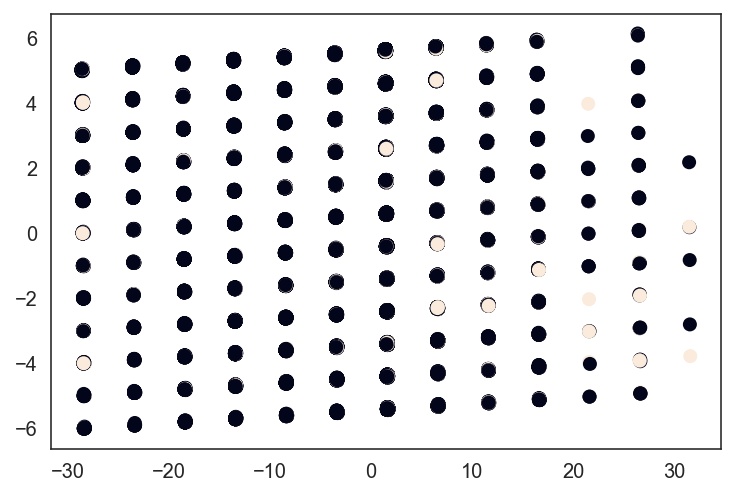

In [59]:
plt.scatter(X_train_pca[:,0],X_train_pca[:,1],c=y_train);

Fitting 3 folds for each of 15 candidates, totalling 45 fits


2019 Train_Set Tuning Results:
Estimator:
Pipeline(steps=[('scale', MinMaxScaler()), ('pca', PCA(n_components=2)),
                ('classifier',
                 SGDClassifier(class_weight='balanced', l1_ratio=1, loss='log',
                               n_jobs=4))])

Best Result (Suggested):
	                      train  valdn
	                  f1   0.28   0.28
	              recall   0.58   0.58
	           precision   0.19   0.19
	   balanced_accuracy   0.59   0.59
	            accuracy   0.59   0.59
	             roc_auc   0.63   0.63

Params:
	{'classifier__alpha': 0.0001, 'classifier__l1_ratio': 1}



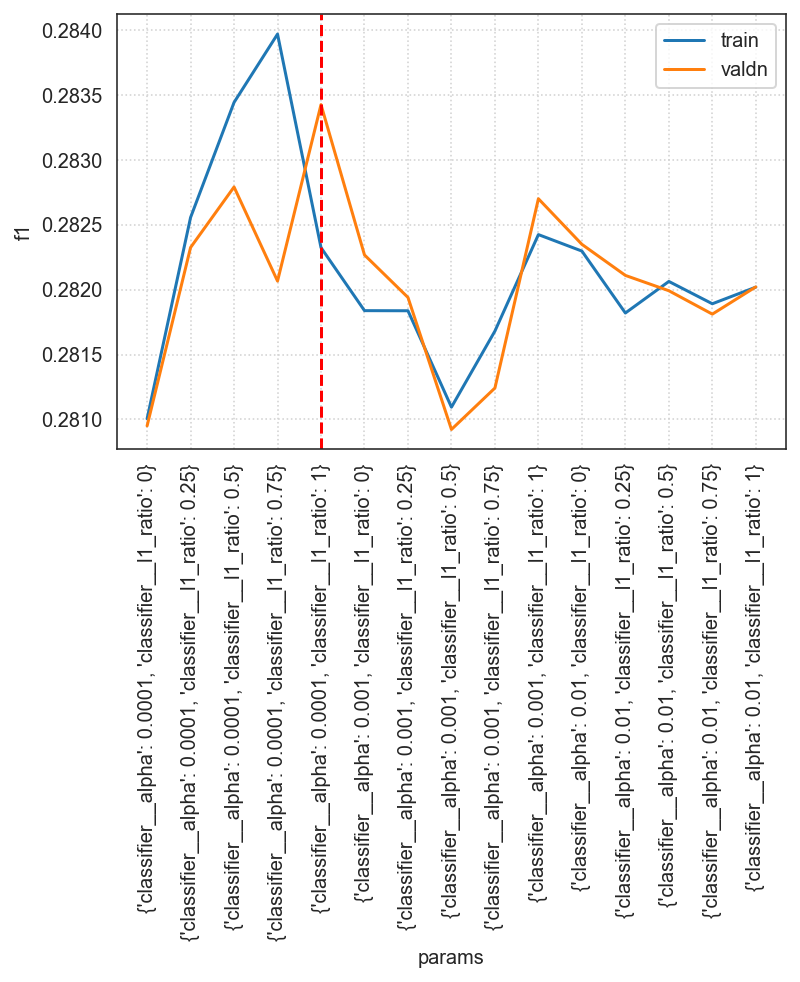

param                        f1       recall       precision       balanced_accuracy       accuracy  \
   classifier__alpha classifier__l1_ratio test train   test train      test train              test train     test   
0             0.0001                    0 0.28  0.28   0.57  0.57      0.19  0.19              0.58  0.58     0.59   
1             0.0001                 0.25 0.28  0.28   0.57  0.57      0.19  0.19              0.59  0.59      0.6   
2             0.0001                  0.5 0.28  0.28   0.55  0.55      0.19  0.19              0.59  0.59     0.61   
3             0.0001                 0.75 0.28  0.28    0.6   0.6      0.19  0.19              0.59  0.59     0.58   
4             0.0001                    1 0.28  0.28   0.58  0.58      0.19  0.19              0.59  0.59     0.59   
5              0.001                    0 0.28  0.28   0.56  0.56      0.19  0.19              0.59  0.58     0.61   
6              0.001                 0.25 0.28  0.28   0.56  0.56      0.19  0.19              0.59  0.58     0.61   
7              0.001                  0.5 0.28  0.28   0.56  0.56      0.19  0.19              0.58  0.58      0.6   
8              0.001                 0.75 0.28  0.28   0.56  0.56      0.19  0.19              0.58  0.58      0.6   
9              0.001                    1 0.28  0.28   0.56  0.56      0.19  0.19              0.59  0.59     0.61   
10              0.01                    0 0.28  0.28   0.56  0.56      0.19  0.19              0.59  0.59     0.61   
11              0.01                 0.25 0.28  0.28   0.56  0.56      0.19  0.19              0.59  0.58     0.61   
12              0.01                  0.5 0.28  0.28   0.56  0.56      0.19  0.19              0.59  0.59     0.61   
13              0.01                 0.75 0.28  0.28   0.56  0.56      0.19  0.19              0.58  0.59      0.6   
14              0.01                    1 0.28  0.28   0.56  0.56      0.19  0.19              0.59  0.59     0.61   

         roc_auc        
   train    test train  
0   0.59    0.63  0.63  
1    0.6    0.63  0.63  
2   0.62    0.63  0.63  
3   0.58    0.63  0.63  
4   0.59    0.63  0.63  
5   0.61    0.64  0.64  
6   0.61    0.64  0.64  
7    0.6    0.64  0.64  
8   0.61    0.63  0.63  
9   0.61    0.63  0.63  
10  0.61    0.64  0.64  
11  0.61    0.64  0.64  
12  0.61    0.64  0.64  
13  0.61    0.64  0.64  
14  0.61    0.64  0.64



2019 Test_Set Results:
accuracy score:           0.59
f1 score:                 0.28
recall score:             0.57
precision score:          0.18
balanced_accuracy score:  0.58
roc_auc score:            0.58


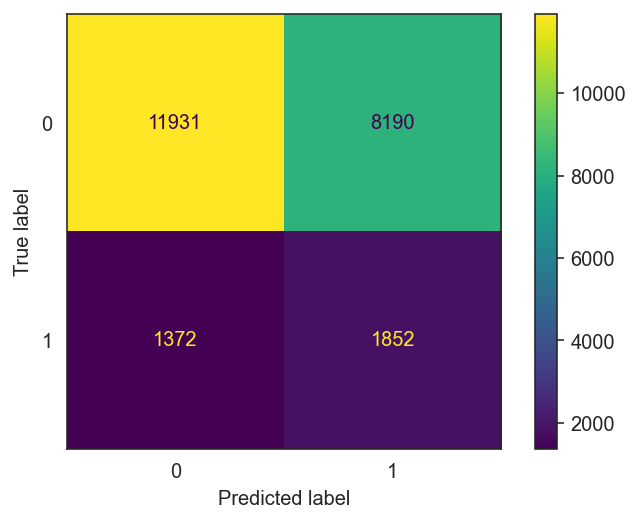



2020 Results:
accuracy score:           0.59
f1 score:                 0.31
recall score:             0.58
precision score:          0.21
balanced_accuracy score:  0.59
roc_auc score:            0.59


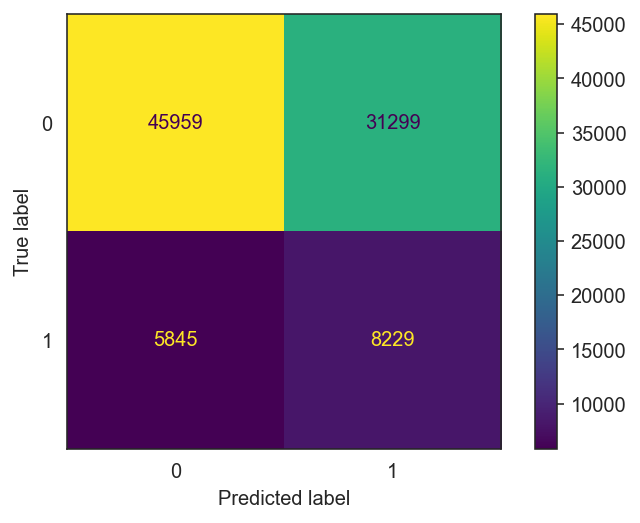

In [58]:
cl_pl = Pipeline(
    steps=[
        ('scale', MinMaxScaler()),
        ('pca', PCA(2)),
        ('classifier', SGDClassifier(loss='log',n_jobs=n_jobs,class_weight='balanced'))
    ]
)

params = {
#    'classifier__class_weight': ['balanced',{1:2},{1:3},{1:4}],
    'classifier__l1_ratio': [0,.25,.5,.75,1],
    'classifier__alpha': [1e-4, 1e-3, 1e-2],#np.logspace(-4,-3,5).round(5),
#    'classifier__alpha': [.0006,.0007,.0008],
}
gs_sgd = GridSearchCV(
    cl_pl,
    params, **grid_search_defaults
)
gs_sgd.fit(
    X_train,
    y_train
)

print(f'\n\n{StartBold}2019 Train_Set Tuning Results:{EndBold}')
plot_grid_search_results(gs_sgd, grid_search_defaults['refit'])
print(f'\n\n{StartBold}2019 Test_Set Results:{EndBold}')
score_classification_model(gs_sgd, X_test, y_test)
print(f'\n\n{StartBold}2020 Results:{EndBold}')
results = score_classification_model(gs_sgd, features_2020_dm, target_2020, True)
scores_2020.update(results)

## Kernel PCA

In [60]:
from sklearn.decomposition import KernelPCA

In [ ]:
_kpca = KernelPCA(2).fit(X_train)

In [ ]:
_kpca.explained_variance_ratio_

In [44]:
X_train_kpca = _kpca.transform(X_train)

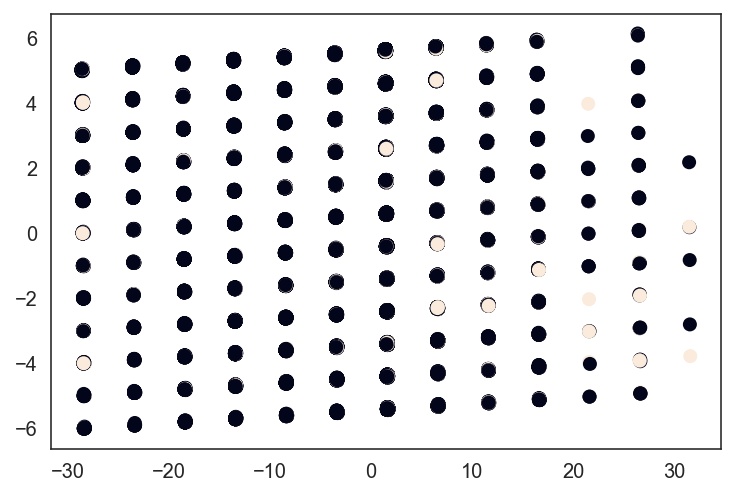

In [59]:
plt.scatter(X_train_kpca[:,0],X_train_kpca[:,1],c=y_train);

# Notify Me When Done

In [ ]:
# Send notification to my mobile when done (will not work if script not found)
if("prowl_notify" in globals()): prowl_notify('ALL DONE')

# 2020 Results Table

In [ ]:
pd.DataFrame(scores_2020).T

In [ ]:
pd.DataFrame(scores_2020).T.to_csv('scores_m_2020_logreg.csv')